In [1]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, LSTM, Dense, Dropout, Reshape, BatchNormalization, GRU, Bidirectional, LeakyReLU
from tensorflow.keras.models import Model
import random
import seaborn as sns
from sklearn.metrics import confusion_matrix


In [2]:
# Function to load audio files and extract MFCCs
def load_audio_files(data_path):
    features, labels = [], []
    for actor in os.listdir(data_path):
        actor_path = os.path.join(data_path, actor)
        if os.path.isdir(actor_path):
            for file in os.listdir(actor_path):
                file_path = os.path.join(actor_path, file)
                if file.endswith(".wav"):
                    signal, sr = librosa.load(file_path, sr=22050)
                    mfccs = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=40)
                    features.append(mfccs.T)
                    labels.append(file.split('-')[2])
    return features, labels

In [3]:
data_path = "./Audio_Speech_Actors_01-24"  # Change to actual dataset path
features, labels = load_audio_files(data_path)

# Encode labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)
labels = to_categorical(labels)

# Padding sequences to the same length
max_len = max(len(feature) for feature in features)
features_padded = np.array([np.pad(f, ((0, max_len - len(f)), (0, 0)), mode='constant') for f in features])

# Splitting dataset
X_train, X_test, y_train, y_test = train_test_split(features_padded, labels, test_size=0.2, random_state=42)

# Reshape input to fit CNN input expectations
X_train = np.expand_dims(X_train, axis=-1)  # Shape: (samples, time, features, 1)
X_test = np.expand_dims(X_test, axis=-1)


In [7]:
class EmotionCNNLSTM(Model):
    def __init__(self, input_shape, num_classes):
        super(EmotionCNNLSTM, self).__init__()
        self.conv1 = Conv2D(32, (3, 3), padding='same')
        self.activation1 = LeakyReLU()
        self.bn1 = BatchNormalization()
        self.pool1 = MaxPooling2D((2, 2))
        self.dropout1 = Dropout(0.4)

        self.conv2 = Conv2D(64, (3, 3), padding='same')
        self.activation2 = LeakyReLU()
        self.bn2 = BatchNormalization()
        self.pool2 = MaxPooling2D((2, 2))
        self.dropout2 = Dropout(0.4)

        self.conv3 = Conv2D(128, (3, 3), padding='same')
        self.activation3 = LeakyReLU()
        self.bn3 = BatchNormalization()
        self.pool3 = MaxPooling2D((2, 2))
        self.dropout3 = Dropout(0.4)

        self.reshape = Reshape((-1, 128))
        self.lstm = Bidirectional(LSTM(128, return_sequences=False))
        self.dense1 = Dense(128, activation='relu')
        self.dropout4 = Dropout(0.5)
        self.dense2 = Dense(num_classes, activation='softmax')

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.activation1(x)
        x = self.bn1(x)
        x = self.pool1(x)
        x = self.dropout1(x)
        
        x = self.conv2(x)
        x = self.activation2(x)
        x = self.bn2(x)
        x = self.pool2(x)
        x = self.dropout2(x)
        
        x = self.conv3(x)
        x = self.activation3(x)
        x = self.bn3(x)
        x = self.pool3(x)
        x = self.dropout3(x)
        
        x = self.reshape(x)
        x = self.lstm(x)
        x = self.dense1(x)
        x = self.dropout4(x)
        return self.dense2(x)

# Improved Model class implementation with GRU
class EmotionCNNGRU(Model):
    def __init__(self, input_shape, num_classes):
        super(EmotionCNNGRU, self).__init__()
        self.conv1 = Conv2D(32, (3, 3), padding='same')
        self.activation1 = LeakyReLU()
        self.bn1 = BatchNormalization()
        self.pool1 = MaxPooling2D((2, 2))
        self.dropout1 = Dropout(0.3)

        self.conv2 = Conv2D(64, (3, 3), padding='same')
        self.activation2 = LeakyReLU()
        self.bn2 = BatchNormalization()
        self.pool2 = MaxPooling2D((2, 2))
        self.dropout2 = Dropout(0.3)

        self.reshape = Reshape((-1, 64))
        self.gru = Bidirectional(GRU(128, return_sequences=False))
        self.dense1 = Dense(128, activation='relu')
        self.dropout3 = Dropout(0.5)
        self.dense2 = Dense(num_classes, activation='softmax')

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.activation1(x)
        x = self.bn1(x)
        x = self.pool1(x)
        x = self.dropout1(x)
        
        x = self.conv2(x)
        x = self.activation2(x)
        x = self.bn2(x)
        x = self.pool2(x)
        x = self.dropout2(x)
        
        x = self.reshape(x)
        x = self.gru(x)
        x = self.dense1(x)
        x = self.dropout3(x)
        return self.dense2(x)


In [8]:
# Model selection
input_shape = (max_len, 40, 1)  # (Time, Features, Channel)
num_classes = labels.shape[1]
model = EmotionCNNLSTM(input_shape, num_classes)

# Compile and train model
model.compile(loss='crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30, batch_size=32)

Epoch 1/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 11s 207ms/step - accuracy: 0.1897 - loss: 2.0576 - val_accuracy: 0.2361 - val_loss: 1.9425
Epoch 2/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 196ms/step - accuracy: 0.2424 - loss: 1.9472 - val_accuracy: 0.2049 - val_loss: 1.9543
Epoch 3/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 194ms/step - accuracy: 0.2044 - loss: 1.9409 - val_accuracy: 0.2188 - val_loss: 1.9153
Epoch 4/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 199ms/step - accuracy: 0.2247 - loss: 1.9238 - val_accuracy: 0.2257 - val_loss: 1.8956
Epoch 5/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 226ms/step - accuracy: 0.2593 - loss: 1.8702 - val_accuracy: 0.2639 - val_loss: 1.8432
Epoch 6/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 220ms/step - accuracy: 0.2750 - loss: 1.8487 - val_accuracy: 0.2604 - val_loss: 1.8770
Epoch 7/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 209ms/step - accuracy: 0.3045 - loss: 1.7991 - val_accuracy: 0.2917 - val_loss: 1.8349
Epoch 8/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 217ms/step - accuracy: 0.2882 - loss: 1.8076 - val_accuracy: 0

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step


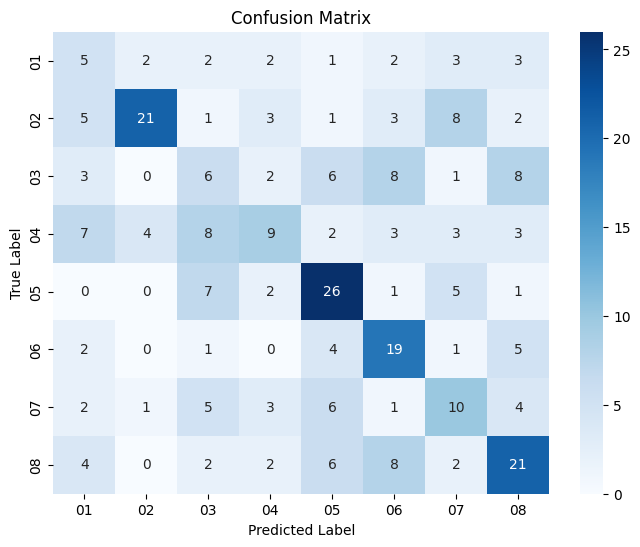

In [6]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  
y_true = np.argmax(y_test, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
